# Code for Section 6.4.1 Return and Risk Stacking

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from copy import copy

In [2]:
# Load instrument info
instrument_names, means, covariance_matrix = ft.load_parameters()

In [3]:
# Specify base long-only constraints
I = len(instrument_names)
G = -np.eye(I)
h = np.zeros(I)
mv_opt = ft.MeanVariance(means, covariance_matrix, G, h)

In [4]:
# Parameter uncertainty specification
B = 1000  # Number of efficient frontiers
P = 9  # Number of portfolios used to span the efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(0)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [5]:
# Base frontier with no parameter uncertainty
frontier = mv_opt.efficient_frontier(P)
results = np.full((P, 2), np.nan)
results[:, 0] = means @ frontier
for p in range(P):
    results[p, 1] = frontier[:, p] @ covariance_matrix @ frontier[:, p]

In [6]:
def marginal_vol_contributions(covariance_matrix, exposures):
    """Function for computing the marginal volatility contributions.

    Args:
        covariance_matrix: Covariance matrix with shape (I, I).
        exposures: Portfolio exposures with shape (I).
    """
    marginal_vols = covariance_matrix @ exposures / np.sqrt(exposures.T @ covariance_matrix @ exposures)
    marginal_vol_contributions = marginal_vols * exposures
    return marginal_vol_contributions, marginal_vols

In [7]:
# Validate and illustrate marginal_vol_contributions use
pf_index = 4
pf_frontier = frontier[:, pf_index]
marg_cont, marg = marginal_vol_contributions(covariance_matrix, pf_frontier)
pf_vol = np.sqrt(pf_frontier.T @ covariance_matrix @ pf_frontier)
print(f'Difference between contributions sum and portfolio volatility = {pf_vol - np.sum(marg_cont)}.')
pd.DataFrame(np.round(100 * marg_cont, 2), index=instrument_names, columns=['Marginal vol contribution'])

Difference between contributions sum and portfolio volatility = 1.3877787807814457e-17.


,Marginal vol contribution
Gov & MBS,-0.00
Corp IG,0.00
Corp HY,0.00
EM Debt,0.00
DM Equity,0.00
EM Equity,0.00
Private Equity,4.38
Infrastructure,3.10
Real Estate,0.53
Hedge Funds,1.60


In [8]:
# Mean uncertainty
frontier_mean = np.full((I, P, B), np.nan)
return_cont = np.full((I, B), np.nan)
vol_cont = np.full((I, B), np.nan)
return_vol = np.full((I, B), np.nan)
for b in range(B):
    means_run = np.mean(return_sim[:, b, :], axis=0)
    mv_opt._expected_return_row = -matrix(means_run).T
    frontier_mean[:, :, b] = mv_opt.efficient_frontier(P)
    return_cont[:, b] = means_run * frontier_mean[:, pf_index, b]
    cov_run = np.cov(return_sim[:, b, :], rowvar=False)
    vol_cont[:, b] = marginal_vol_contributions(cov_run, frontier_mean[:, pf_index, b])[0]
    return_vol[:, b] = return_cont[:, b] / vol_cont[:, b]

In [9]:
def resampled_stacking(L, sample_targets):
    """Computes the L-fold Resampled Portfolio Stacking sample weights.

    Args:
        L: Number of partition sets.
        sample_targets: Sample portfolio exposures with shape (I, B) or (1, B).

    Returns:
        Stacking sample weights.
    """
    B = sample_targets.shape[1]
    partition_size = B // L  # size of validation set for all except possibly the last
    indices = np.arange(0, B)
    partitions = [indices[l * partition_size:(l + 1) * partition_size] for l in range(L - 1)]
    partitions.append(indices[(L - 1) * partition_size:])

    M = sample_targets.T
    P = np.zeros((B, B))
    q = np.zeros((B, 1))
    for K_l in partitions:
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(sample_targets[:, K_l], axis=1)
        q = q + len(K_l)**-1 * (M_l @ sum_exposures_K_l)[:, np.newaxis]

    P = matrix(2 * P)
    q = matrix(-2 * q)
    A = matrix(np.ones((1, B)))
    b = matrix(np.array([[1.]]))
    G = matrix(-np.identity(B))
    h = matrix(np.zeros((B, 1)))
    w = solvers.qp(P, q, G, h, A, b)['x']
    return np.array(w)

In [10]:
# Compute portfolios
L = 5  # Most interesting results
pf_frontier = frontier[:, pf_index]
pf_re = np.mean(frontier_mean[:, pf_index, :], axis=1)
pf_es = ft.exposure_stacking(L, frontier_mean[:, pf_index, :])
w_return = resampled_stacking(L, return_cont)
pf_return = frontier_mean[:, pf_index, :] @ w_return
w_vol = resampled_stacking(L, vol_cont)
pf_vol = frontier_mean[:, pf_index, :] @ w_vol
w_return_vol = resampled_stacking(L, return_vol)
pf_return_vol = frontier_mean[:, pf_index, :] @ w_return_vol

In [11]:
# Results Table 6.4 - 6.7
pf_results = np.vstack((pf_re, pf_es, pf_return[:, 0], pf_vol[:, 0], pf_return_vol[:, 0], pf_frontier)).T
pf_means = means @ pf_results
pf_vols = np.full(pf_results.shape[1], np.nan)
for i in range(len(pf_vols)):
    pf_vols[i] = np.sqrt(pf_results[:, i].T @ covariance_matrix @ pf_results[:, i])
pf_results2 = np.vstack((pf_results, pf_means[np.newaxis, :], pf_vols[np.newaxis, :]))
pf_df = pd.DataFrame(
    np.round(100 * pf_results2, 2), index=instrument_names + ['Mean'] + ['Vol'], 
    columns=['Resampled', 'Exposure', 'Return', 'Risk', 'Return / Risk', 'Frontier'])
pf_df

,Resampled,Exposure,Return,Risk,Return / Risk,Frontier
Gov & MBS,0.12,0.00,0.01,0.00,0.00,0.00
Corp IG,0.00,0.00,0.00,0.00,0.00,0.00
Corp HY,0.00,0.00,0.00,0.00,0.00,0.00
EM Debt,4.88,1.27,5.21,1.85,2.25,0.00
DM Equity,0.48,0.00,0.52,0.00,0.00,0.00
EM Equity,0.07,0.00,0.06,0.00,0.00,0.00
Private Equity,18.07,17.76,18.26,20.33,16.19,20.41
Infrastructure,34.35,38.11,34.12,34.81,38.16,40.49
Real Estate,16.36,15.62,16.29,15.55,20.57,11.06
Hedge Funds,25.66,27.25,25.53,27.47,22.82,28.04


# Out-of-sample testing

In [12]:
# Out-of-sample simulations
return_sim_oos = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [13]:
def risk_return(pf):
    """Computes the out of sample risk and return of the portfolio.

    Args:
        pf: Portfolio to measure risk and return against.

    Returns:
        Array of shape (2, B) with risk and return for each of the B simulations.
    """
    risk_return = np.full((2, B), np.nan)
    for b in range(B):
        means_run = np.mean(return_sim_oos[:, b, :], axis=0)
        cov_run = np.cov(return_sim_oos[:, b, :], rowvar=False)
        risk_return[0, b] = pf @ cov_run @ pf
        risk_return[1, b] = means_run @ pf
    return risk_return

In [14]:
# Across methods
re_rr = risk_return(pf_re)
re_rar = re_rr[1, :] / re_rr[0, :]
es_rr = risk_return(pf_es)
es_rar = es_rr[1, :] / es_rr[0, :]
return_rr = risk_return(pf_return[:, 0])
return_rar = return_rr[1, :] / return_rr[0, :]
vol_rr = risk_return(pf_vol[:, 0])
vol_rar = vol_rr[1, :] / vol_rr[0, :]
return_vol_rr = risk_return(pf_return_vol[:, 0])
return_vol_rar = return_vol_rr[1, :] / return_vol_rr[0, :]
frontier_rr = risk_return(frontier[:, pf_index])
frontier_rar = frontier_rr[1, :] / frontier_rr[0, :]

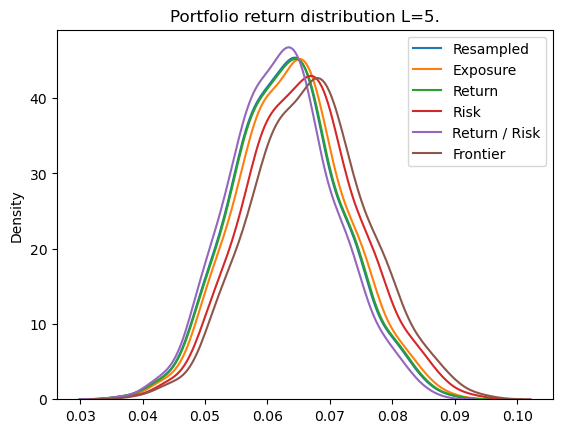

In [15]:
sns.kdeplot(x=re_rr[1, :])
sns.kdeplot(x=es_rr[1, :])
sns.kdeplot(x=return_rr[1, :])
sns.kdeplot(x=vol_rr[1, :])
sns.kdeplot(x=return_vol_rr[1, :])
sns.kdeplot(x=frontier_rr[1, :])
plt.title(f'Portfolio return distribution L={L}.')
plt.legend(['Resampled', 'Exposure', 'Return', 'Risk', 'Return / Risk', 'Frontier'])
plt.show()

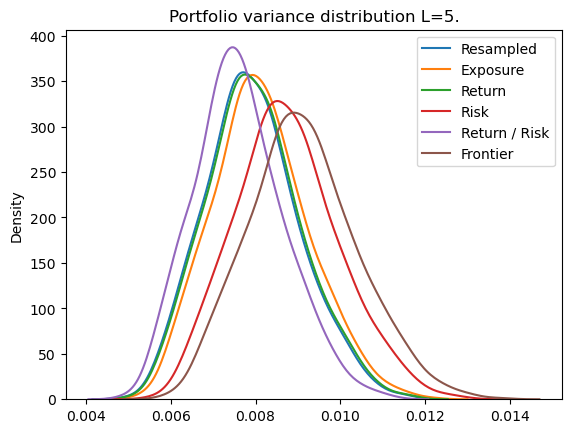

In [16]:
sns.kdeplot(x=re_rr[0, :])
sns.kdeplot(x=es_rr[0, :])
sns.kdeplot(x=return_rr[0, :])
sns.kdeplot(x=vol_rr[0, :])
sns.kdeplot(x=return_vol_rr[0, :])
sns.kdeplot(x=frontier_rr[0, :])
plt.title(f'Portfolio variance distribution L={L}.')
plt.legend(['Resampled', 'Exposure', 'Return', 'Risk', 'Return / Risk', 'Frontier'])
plt.show()

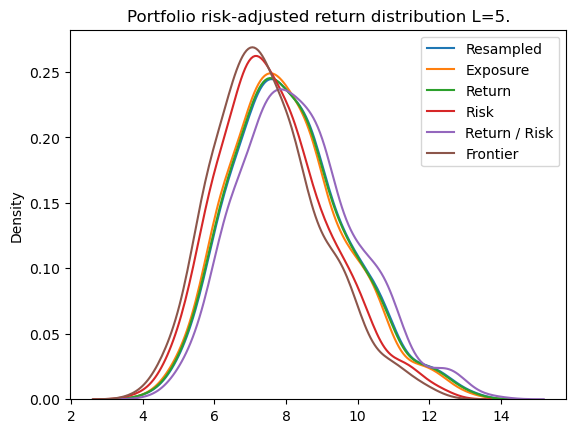

In [17]:
sns.kdeplot(x=re_rar)
sns.kdeplot(x=es_rar)
sns.kdeplot(x=return_rar)
sns.kdeplot(x=vol_rar)
sns.kdeplot(x=return_vol_rar)
sns.kdeplot(x=frontier_rar)
plt.title(f'Portfolio risk-adjusted return distribution L={L}.')
plt.legend(['Resampled', 'Exposure', 'Return', 'Risk', 'Return / Risk', 'Frontier'])
plt.show()

In [18]:
# Across L for Return / Risk Stacking
Ls = [2, 5, 20, B]
stacking_target = return_vol
w0 = resampled_stacking(Ls[0], stacking_target)
w1 = resampled_stacking(Ls[1], stacking_target)
w2 = resampled_stacking(Ls[2], stacking_target)
w3 = resampled_stacking(Ls[3], stacking_target)
pf0 = frontier_mean[:, pf_index, :] @ w0
pf1 = frontier_mean[:, pf_index, :] @ w1
pf2 = frontier_mean[:, pf_index, :] @ w2
pf3 = frontier_mean[:, pf_index, :] @ w3
rr0 = risk_return(pf0[:, 0])
rr1 = risk_return(pf1[:, 0])
rr2 = risk_return(pf2[:, 0])
rr3 = risk_return(pf3[:, 0])
rar0 = rr0[1, :] / rr0[0, :]
rar1 = rr1[1, :] / rr1[0, :]
rar2 = rr2[1, :] / rr2[0, :]
rar3 = rr3[1, :] / rr3[0, :]

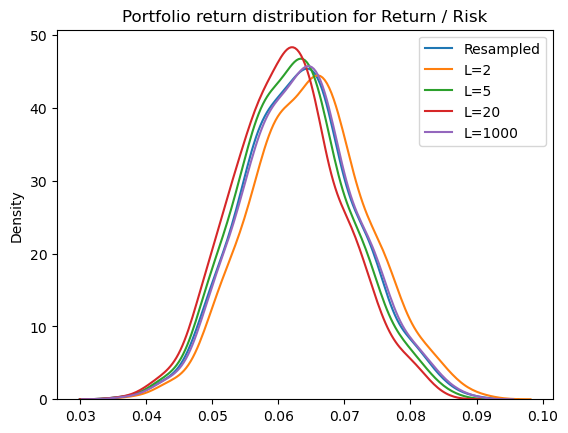

In [19]:
sns.kdeplot(x=re_rr[1, :])
sns.kdeplot(x=rr0[1, :])
sns.kdeplot(x=rr1[1, :])
sns.kdeplot(x=rr2[1, :])
sns.kdeplot(x=rr3[1, :])
plt.title(f'Portfolio return distribution for Return / Risk')
plt.legend(['Resampled', f'L={Ls[0]}', f'L={Ls[1]}', f'L={Ls[2]}', f'L={Ls[3]}'])
plt.show()

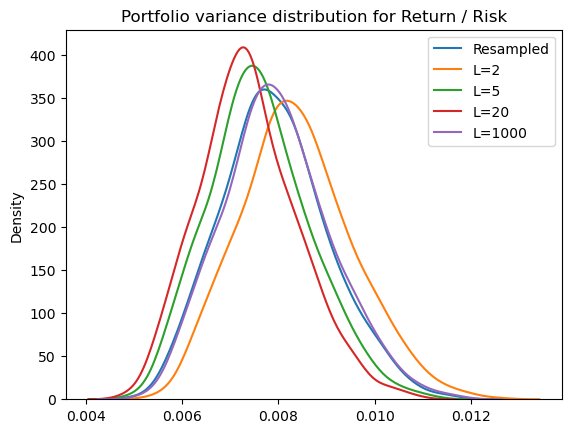

In [20]:
sns.kdeplot(x=re_rr[0, :])
sns.kdeplot(x=rr0[0, :])
sns.kdeplot(x=rr1[0, :])
sns.kdeplot(x=rr2[0, :])
sns.kdeplot(x=rr3[0, :])
plt.title(f'Portfolio variance distribution for Return / Risk')
plt.legend(['Resampled', f'L={Ls[0]}', f'L={Ls[1]}', f'L={Ls[2]}', f'L={Ls[3]}'])
plt.show()

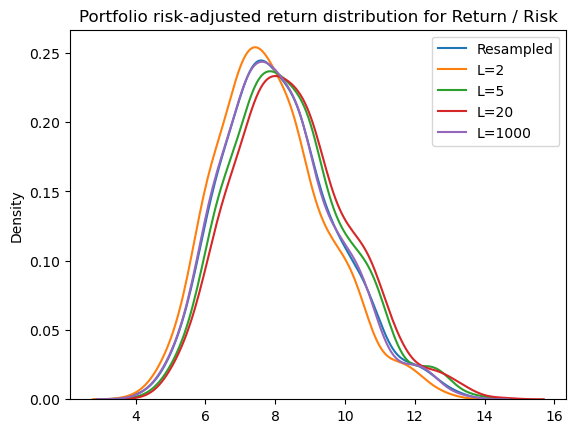

In [21]:
sns.kdeplot(x=re_rar)
sns.kdeplot(x=rar0)
sns.kdeplot(x=rar1)
sns.kdeplot(x=rar2)
sns.kdeplot(x=rar3)
plt.title(f'Portfolio risk-adjusted return distribution for Return / Risk')
plt.legend(['Resampled', f'L={Ls[0]}', f'L={Ls[1]}', f'L={Ls[2]}', f'L={Ls[3]}'])
plt.show()

In [ ]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.